# IMDB movie review sentiment classification with RNNs

In this notebook, we'll train a recurrent neural network (RNN) for sentiment classification using Keras (Tensorflow as the compute backend).  Keras version $\ge$ 2 is required. 

First, the needed imports. Keras tells us which backend (Theano, Tensorflow, CNTK) it will be using.

In [9]:
%matplotlib inline

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout
from keras.layers import LSTM
from keras.datasets import imdb

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## IMDB data set

Next we'll load the IMDB data set. First time we may have to download the data, which can take a while.

The dataset contains 50000 movies reviews from the Internet Movie Database, split into 25000 reviews for training and 25000 reviews for testing. 

**Half of the reviews are positive (1) and half are negative (0).**

The dataset has already been preprocessed, and each word has been replaced by an integer index.

The reviews are thus represented as varying-length sequences of integers.

In [10]:
# number of most-frequent words to use
nb_words = 10000

# cut texts after this number of words (review length)
maxlen = 80

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=nb_words)
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)
print()

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
x_train: (25000,)
x_test: (25000,)

Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


The first movie review in the training set:

In [11]:
print("First review in the training set:\n", x_train[0], "length:", len(x_train[0]), "class:", y_train[0])

First review in the training set:
 [  15  256    4    2    7 3766    5  723   36   71   43  530  476   26
  400  317   46    7    4    2 1029   13  104   88    4  381   15  297
   98   32 2071   56   26  141    6  194 7486   18    4  226   22   21
  134  476   26  480    5  144   30 5535   18   51   36   28  224   92
   25  104    4  226   65   16   38 1334   88   12   16  283    5   16
 4472  113  103   32   15   16 5345   19  178   32] length: 80 class: 1


## Initialization

Let's create an RNN model that has one (or optionally two) LSTM layers. Dropout  The first layer in the network is an *Embedding* layer that converts integer indices to dense vectors of length `embedding_dims`. The output layer contains a single neuron and *sigmoid* non-linearity to match the binary groundtruth (`y_train`). 

Finally, we `compile()` the model, using *binary crossentropy* as the loss function and [*RMSprop*](https://keras.io/optimizers/#rmsprop) as the optimizer.

In [12]:
# model parameters:
embedding_dims = 50
lstm_units = 32

print('Build model...')
model = Sequential()

# TODO: Explore word embeddings
model.add(Embedding(nb_words,
                    embedding_dims,
                    input_length=maxlen))

model.add(Dropout(0.2))

model.add(LSTM(lstm_units))

# or if running on a GPU:
#model.add(CuDNNLSTM(lstm_units))

# To stack multiple RNN layers, all RNN layers except the last one need
# to have "return_sequences=True".  An example of using two RNN layers:
#model.add(LSTM(lstm_units, return_sequences=True))
#model.add(LSTM(lstm_units))

model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 80, 50)            500000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 80, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 510,657
Trainable params: 510,657
Non-trainable params: 0
_________________________________________________________________
None


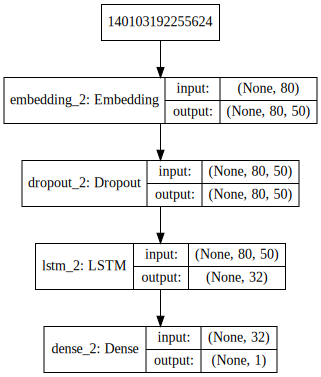

In [13]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Learning

Now we are ready to train our model.  An *epoch* means one pass through the whole training data. Note also that we are using a fraction of the training data as our validation set.

Note that LSTMs are rather slow to train.

In [14]:
%%time
epochs = 5
validation_split = 0.2

history = model.fit(x_train, y_train, batch_size=128,
          epochs=epochs, 
          validation_split=validation_split)


Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 19s 951us/step - loss: 0.5164 - acc: 0.7450 - val_loss: 0.4507 - val_acc: 0.7894
Epoch 2/5
20000/20000 [==============================] - 15s 769us/step - loss: 0.3295 - acc: 0.8622 - val_loss: 0.3526 - val_acc: 0.8416
Epoch 3/5
20000/20000 [==============================] - 15s 762us/step - loss: 0.2765 - acc: 0.8878 - val_loss: 0.3770 - val_acc: 0.8336
Epoch 4/5
20000/20000 [==============================] - 14s 722us/step - loss: 0.2500 - acc: 0.8998 - val_loss: 0.3553 - val_acc: 0.8446
Epoch 5/5
20000/20000 [==============================] - 15s 754us/step - loss: 0.2295 - acc: 0.9097 - val_loss: 0.3885 - val_acc: 0.8438
CPU times: user 2min 12s, sys: 2min 13s, total: 4min 25s
Wall time: 1min 20s


Let's plot the data to see how the training progressed. A big gap between training and validation accuracies would suggest overfitting.

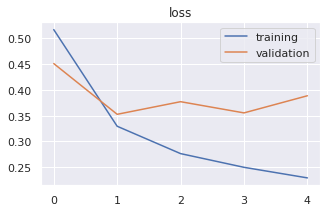

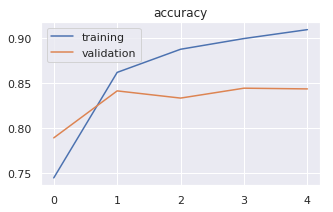

In [15]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'], label='training')
plt.plot(history.epoch,history.history['val_loss'], label='validation')
plt.title('loss')
plt.legend(loc='best')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'], label='training')
plt.plot(history.epoch,history.history['val_acc'], label='validation')
plt.title('accuracy')
plt.legend(loc='best');

## Inference

For a better measure of the quality of the model, let's see the model accuracy for the test data. 

In [16]:
scores = model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 83.69%
